# Clone git

In [1]:
!git clone https://github.com/ttharden/Keyframe-Extraction-for-video-summarization

Cloning into 'Keyframe-Extraction-for-video-summarization'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 197 (delta 30), reused 20 (delta 19), pack-reused 159 (from 1)
Receiving objects: 100% (197/197), 2.55 MiB | 32.70 MiB/s, done.
Resolving deltas: 100% (47/47), done.


# Import Thư viện

In [2]:
import sys
import os
import pickle
import numpy as np

# Thêm đường dẫn gốc

In [3]:
sys.path.append("/kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction")

# Đọc embeding

In [4]:
embedding_path = '/kaggle/input/aic-sample-test/embeddings/L21_V003_features.pkl'
shots_file = '/kaggle/input/aic-sample-test/shots_boundary/L21_V003.txt' 

In [5]:
with open(embedding_path, "rb") as f:
    embeddings = pickle.load(f)

print(type(embeddings))   # numpy.ndarray
print(embeddings.shape)   # số hàng, số chiều embedding
print(embeddings[:2])     # in 2 vector đầu

<class 'numpy.ndarray'>
(29946, 1024)
[[ 0.00845923 -0.05595556  0.01269358 ... -0.00394424  0.00808194
   0.04025413]
 [ 0.01515828 -0.04746538  0.00996778 ...  0.00369519  0.00596431
   0.03616055]]


# Đọc shot file

In [6]:
def read_ranges(file_path):
    """
    Đọc file txt có dạng:
        start end
    Mỗi dòng chứa 2 số nguyên.
    
    Args:
        file_path (str): đường dẫn đến file .txt
    
    Returns:
        list[tuple[int, int]]: danh sách các cặp (start, end)
    """
    ranges = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:  # bỏ dòng trống
                continue
            parts = line.split()
            if len(parts) == 2:
                start, end = map(int, parts)
                ranges.append((start, end))
    return ranges


# Ví dụ dùng:
ranges = read_ranges(shots_file)
print(ranges)
# [(0, 52), (54, 342), (343, 410), ...]

[(0, 297), (298, 360), (361, 392), (393, 425), (426, 450), (451, 488), (489, 528), (529, 556), (557, 586), (587, 614), (615, 690), (691, 727), (728, 792), (793, 1429), (1430, 1578), (1579, 1653), (1654, 1704), (1705, 1839), (1840, 1915), (1916, 1987), (1988, 2058), (2059, 2138), (2139, 2206), (2207, 2280), (2281, 2609), (2610, 2977), (2978, 3223), (3224, 3330), (3331, 3379), (3380, 3426), (3427, 3497), (3498, 3619), (3620, 3706), (3707, 3781), (3782, 3851), (3852, 3923), (3924, 4021), (4022, 4106), (4107, 4195), (4196, 4243), (4244, 4675), (4676, 4807), (4808, 4835), (4836, 4872), (4873, 4961), (4962, 5055), (5056, 5105), (5106, 5240), (5241, 5291), (5292, 5462), (5463, 5563), (5564, 5648), (5649, 5797), (5798, 5843), (5844, 5983), (5984, 6045), (6046, 6092), (6093, 6161), (6162, 6310), (6311, 6569), (6570, 6824), (6825, 6928), (6929, 7053), (7054, 7178), (7179, 7303), (7304, 7428), (7429, 7972), (7973, 8217), (8218, 8373), (8374, 8452), (8453, 8508), (8509, 8572), (8573, 8642), (8643,

# Gán nhãn cho embeddings theo shot

In [7]:
len(embeddings)

29946

In [8]:
# Tổng số điểm embedding (ví dụ)
n_samples = len(embeddings)  # bạn thay bằng len(embeddings)

# Tạo mảng label mặc định = -1
labels = np.full(n_samples, -1)

# Gán nhãn cho từng khoảng
for idx, (start, end) in enumerate(ranges):
    labels[start:end+1] = idx   # end inclusive

# Giờ labels[i] sẽ là nhãn của embedding i
print(labels[:100])  # in thử 100 phần tử đầu

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Giảm chiều Umap Plot embedding

In [9]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time

start = time.time()
# 2. Chuẩn hóa dữ liệu trước khi đưa vào UMAP
X_scaled = StandardScaler().fit_transform(embeddings)

# 3. Khởi tạo UMAP giảm chiều về 2D
umap_model = umap.UMAP(
    n_neighbors=50,     # số láng giềng gần, ảnh hưởng đến cấu trúc local
    n_components=2,     # số chiều muốn giảm về (2 hoặc 3)
    metric='euclidean', # khoảng cách sử dụng
)

X_umap = umap_model.fit_transform(X_scaled)
end = time.time()
print(f'Reduce embedding to plot time: {end - start}')

2025-08-24 18:14:20.637967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756059260.851035      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756059260.916181      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Reduce embedding to plot time: 99.69927597045898


In [10]:
X_umap.shape

(29946, 2)

In [11]:
y = labels
print(y)

[  0   0   0 ... 252 252 252]


Saved to umap_plot.png


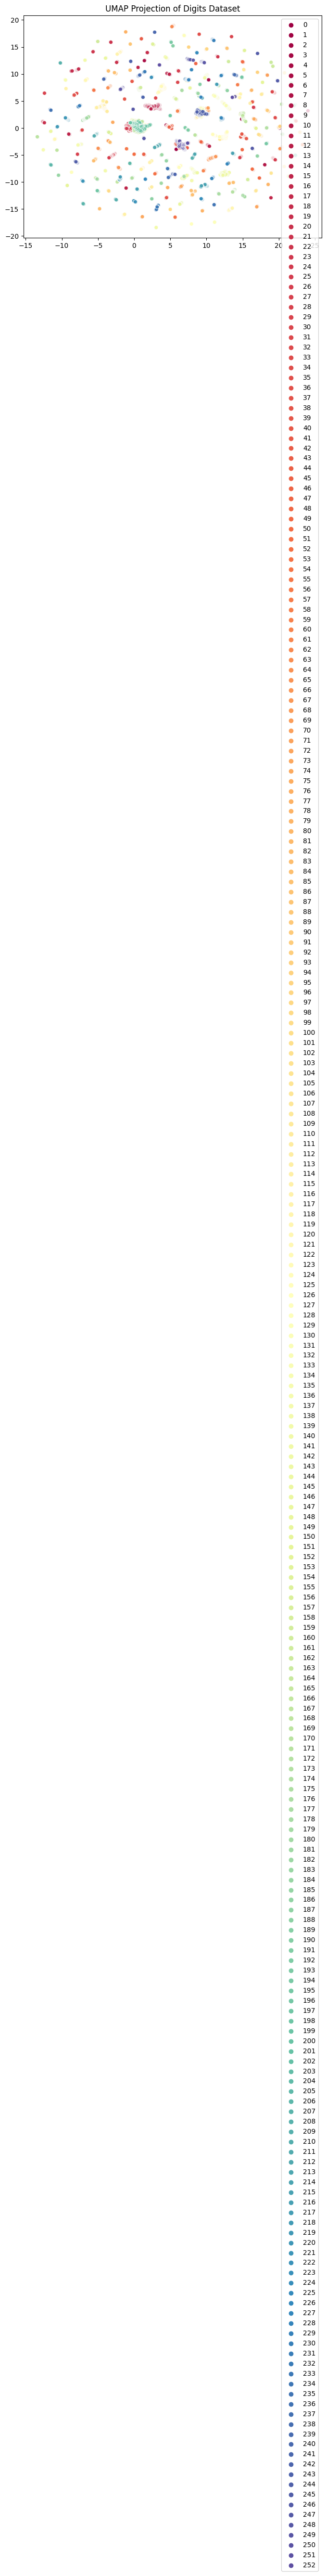

In [12]:
%matplotlib inline

# 4. Vẽ scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_umap[:,0], y=X_umap[:,1],
    hue=y, palette="Spectral",
    legend="full", s=30, alpha=0.8
)
plt.title("UMAP Projection of Digits Dataset")
plt.savefig("umap_plot.png", dpi=300, bbox_inches="tight")
print("Saved to umap_plot.png")

In [13]:
%%writefile /kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction/Keyframe_extraction.py
import pickle
import cv2
import numpy as np

from Kmeans_improvment import kmeans_silhouette
from Redundancy import redundancy
import sys
import os
import json

sys.path.append('/kaggle/working/Keyframe-Extraction-for-video-summarization/src/scripts')
from save_keyframe import save_frames

def scen_keyframe_extraction(scenes_path, features_path, video_path, save_path, folder_path):
    # Get lens segmentation data
    number_list = []
    with open(scenes_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            numbers = line.strip().split(' ')
            number_list.extend([int(number) for number in numbers])

    # Read inference data from local
    with open(features_path, 'rb') as file:
        features = pickle.load(file)

    features = np.asarray(features)
    # print(len(features))

    # Clustering at each shot to obtain keyframe sequence numbers
    keyframe_index = []
    for i in range(0, len(number_list) - 1, 2):
        start = number_list[i]
        end = number_list[i + 1]
        print(start, end)
        sub_features = features[start:end]
        best_labels, best_centers, k, index = kmeans_silhouette(sub_features)
        final_index = [x + start for x in index]
        final_index.sort()
        print("clustering：" + str(keyframe_index))
        print(start, end)
        final_index = redundancy(video_path, final_index, 0.94)
        print("final_index：", final_index)
        keyframe_index += final_index
    keyframe_index.sort()
    print("final_index：" + str(keyframe_index))

    # save keyframe
    save_frames(keyframe_index, video_path, save_path, folder_path)
    return keyframe_index

# ====== CHỈNH ĐƯỜNG DẪN ======
video_path = "/kaggle/input/aic-sample-test/videos/L21_V003.mp4"
scenes_path = "/kaggle/input/aic-sample-test/shots_boundary/L21_V003.txt"
features_path = "/kaggle/input/aic-sample-test/embeddings/L21_V003_features.pkl"

# Nơi lưu keyframes
save_path = "/kaggle/working"
folder_path = "video_keyframes"

os.makedirs(save_path, exist_ok=True)

keyframe_index = scen_keyframe_extraction(
    scenes_path=scenes_path,
    features_path=features_path,
    video_path=video_path,
    save_path=save_path,
    folder_path=folder_path
)

keyframes_index_file = '/kaggle/working/L21_V003_keyframes_index.json'

# Lưu mảng vào file JSON
with open(keyframes_index_file, 'w') as json_file:
    json.dump(keyframe_index, json_file)

print(f'Frameindexs đã được lưu vào file {file_path}')

print(f"✅ Keyframes đã lưu trong {os.path.join(save_path, folder_path)}")

Overwriting /kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction/Keyframe_extraction.py


In [14]:
%%writefile /kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction/init_center.py
import numpy as np
from tqdm import tqdm

def kmeans_init(data):
    print("🔹 In the process of initialising the center")
    n = len(data)
    sqrt_n = int(np.sqrt(n))           # số tâm cần chọn
    centers = []
    label = []

    # pick init_center
    while len(centers) < sqrt_n:
        sse_min = float('inf')
        join_center = data[0]

        # tqdm để quan sát tiến trình duyệt qua n điểm
        for i in tqdm(range(n), desc=f"Selecting center {len(centers)+1}/{sqrt_n}"):
            center = centers.copy()
            
            if len(centers) == 0 or not np.any(np.all(data[i] == centers, axis=1)):
                center.append(data[i])
                center = np.array(center)
                sse = 0.0

                # Cluster operation
                cluster_labels = np.zeros(len(data)).astype(int)
                for k in range(len(data)):
                    distances = [np.sqrt(np.sum((data[k] - cen) ** 2)) for cen in center]
                    nearest_cluster = np.argmin(distances)
                    cluster_labels[k] = nearest_cluster

                # Based on the results of the cluster operation, calculate sse
                for j in range(len(center)):
                    cluster_points = [data[l] for l in range(len(cluster_labels)) if cluster_labels[l] == j]
                    singe_sse = sum(np.linalg.norm(point - center[j]) for point in cluster_points)
                    sse += singe_sse

                if sse < sse_min:
                    sse_min = sse
                    join_center = data[i]
                    label = cluster_labels.copy()

        centers.append(join_center)

    return np.array(label), np.array(centers)

Overwriting /kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction/init_center.py


In [15]:
%%writefile /kaggle/working/Keyframe-Extraction-for-video-summarization/src/scripts/save_keyframe.py
import os
import cv2
from tqdm import tqdm  # Thêm tqdm

def save_frames(keyframe_indexes, video_path, save_path, folder_name):
    # Open video
    cap = cv2.VideoCapture(video_path)

    # Creating a folder path for saving images
    folder_path = os.path.join(save_path, folder_name)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Setting the current frame number
    current_index = 0

    # Cyclic reading of the video frames with tqdm
    for _ in tqdm(range(total_frames), desc="Processing frames", ncols=100):  # Add tqdm here
        ret, frame = cap.read()

        if not ret:
            break

        # Check if the current frame is a keyframe, if yes, save the frame image
        if current_index in keyframe_indexes:
            file_name = f"keyframes_{current_index:010d}.jpg"  # Fix variable name to 'current_index'
            file_path = os.path.join(folder_path, file_name)
            cv2.imwrite(file_path, frame)
        
        current_index += 1

    # release
    cap.release()

Overwriting /kaggle/working/Keyframe-Extraction-for-video-summarization/src/scripts/save_keyframe.py


In [16]:
!python /kaggle/working/Keyframe-Extraction-for-video-summarization/src/extraction/Keyframe_extraction.py

0 297
🔹 In the process of initialising the center
Selecting center 17/17: 100%|█████████████████| 297/297 [00:13<00:00, 21.77it/s]
clustering：[]
0 297
[2, 238]
final_index： [2, 238]
298 360
🔹 In the process of initialising the center
Selecting center 7/7: 100%|████████████████████| 62/62 [00:00<00:00, 261.60it/s]
clustering：[2, 238]
298 360
[301, 340]
final_index： [301, 340]
361 392
🔹 In the process of initialising the center
Selecting center 5/5: 100%|████████████████████| 31/31 [00:00<00:00, 623.81it/s]
clustering：[2, 238, 301, 340]
361 392
381 0.95826477 362
[362]
final_index： [362]
393 425
🔹 In the process of initialising the center
Selecting center 5/5: 100%|████████████████████| 32/32 [00:00<00:00, 590.77it/s]
clustering：[2, 238, 301, 340, 362]
393 425
417 0.9465097 394
422 0.9512686 394
[394]
final_index： [394]
426 450
🔹 In the process of initialising the center
Selecting center 4/4: 100%|████████████████████| 24/24 [00:00<00:00, 918.21it/s]
clustering：[2, 238, 301, 340, 362, 39